In [87]:
import scanpy as sc
import scipy.stats as stats
import pandas as pd
from statsmodels.stats.multitest import fdrcorrection
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

### Differential expression analysis

In [9]:
data_path='../Data/' ##it is a convinience function ##.. is go back

In [10]:
adata=sc.read(data_path + 'fullHBEC.h5ad')

### subset the data

In [4]:
ct='ciliated'
stim='lambda'
tp='3'

In [53]:
gene_filter=adata.X.mean(axis=0).A1>0.01

In [10]:
STIM_COL_NAME='stim'
TIME_COL_NAME='time'
CELLTYPE_COL_NAME='cell_type'


In [112]:
adata.obs['time'].unique()

['9', '24', '3', '48', '6', '0']
Categories (6, object): ['9', '24', '3', '48', '6', '0']

In [150]:
ct=['basal','neuroendo'] #earased ciliated bc it already ran and basal/club= bc 
stim=['alpha', 'beta', 'gamma', 'lambda']
tp=['3','6','9','24']
combo_c_s_t=list(product(ct,stim,tp))
combo_c_s_t

[('basal', 'alpha', '3'),
 ('basal', 'alpha', '6'),
 ('basal', 'alpha', '9'),
 ('basal', 'alpha', '24'),
 ('basal', 'beta', '3'),
 ('basal', 'beta', '6'),
 ('basal', 'beta', '9'),
 ('basal', 'beta', '24'),
 ('basal', 'gamma', '3'),
 ('basal', 'gamma', '6'),
 ('basal', 'gamma', '9'),
 ('basal', 'gamma', '24'),
 ('basal', 'lambda', '3'),
 ('basal', 'lambda', '6'),
 ('basal', 'lambda', '9'),
 ('basal', 'lambda', '24'),
 ('neuroendo', 'alpha', '3'),
 ('neuroendo', 'alpha', '6'),
 ('neuroendo', 'alpha', '9'),
 ('neuroendo', 'alpha', '24'),
 ('neuroendo', 'beta', '3'),
 ('neuroendo', 'beta', '6'),
 ('neuroendo', 'beta', '9'),
 ('neuroendo', 'beta', '24'),
 ('neuroendo', 'gamma', '3'),
 ('neuroendo', 'gamma', '6'),
 ('neuroendo', 'gamma', '9'),
 ('neuroendo', 'gamma', '24'),
 ('neuroendo', 'lambda', '3'),
 ('neuroendo', 'lambda', '6'),
 ('neuroendo', 'lambda', '9'),
 ('neuroendo', 'lambda', '24')]

In [157]:
bc='basal/club'

In [151]:
for i,j, k in combo_c_s_t:
    control= adata[
        (adata.obs[STIM_COL_NAME]=='control')&\
        (adata.obs[CELLTYPE_COL_NAME]==i),gene_filter].copy()
    subset = adata[
        (adata.obs[CELLTYPE_COL_NAME]==i) &\
        (adata.obs[STIM_COL_NAME]==j) &\
        (adata.obs[TIME_COL_NAME]==k), gene_filter].copy()
    sc.pp.normalize_total(control, target_sum=1e4)
    sc.pp.normalize_total(subset, target_sum=1e4)
    sc.pp.log1p(control)
    sc.pp.log1p(subset)
   
    control_expr=control.X.toarray()
    subset_expr=subset.X.toarray()
    mean_difference=subset_expr.mean(axis=0)- control_expr.mean(axis=0)
    ttest_pvalue= stats.ttest_ind(subset_expr,control_expr, axis=0)[1]
    mwu_pvalue=stats.mannwhitneyu(subset_expr,control_expr, axis=0)[1]
    
    genes=subset.var_names.tolist()
    result=pd.DataFrame(
        zip(mean_difference,mwu_pvalue, ttest_pvalue),
        index=genes,
        columns=['effect_size', 'ttest_pval','mwu_pval'])
    result['ttest_pval']=result['ttest_pval'].fillna(1.0)
    result['mwu_pval']=result['mwu_pval'].fillna(1.0)
    
    _,result['ttest_fdr']=fdrcorrection(result['ttest_pval'])
    _,result['mwu_fdr']=fdrcorrection(result['mwu_pval'])
    result.sort_values('mwu_fdr').head(50)
    result.to_csv(data_path+f'{i}_{j}_{k}.csv')


In [160]:
stim1=['alpha', 'beta', 'gamma', 'lambda']
tp1=['3','6','9','24']
combo_s_t=list(product(stim1,tp1))

for s,t in combo_s_t:
    control= adata[
        (adata.obs[STIM_COL_NAME]=='control')&\
        (adata.obs[CELLTYPE_COL_NAME]==bc),gene_filter].copy()
    subset = adata[
        (adata.obs[CELLTYPE_COL_NAME]==bc) &\
        (adata.obs[STIM_COL_NAME]==s) &\
        (adata.obs[TIME_COL_NAME]==t), gene_filter].copy()
    sc.pp.normalize_total(control, target_sum=1e4)
    sc.pp.normalize_total(subset, target_sum=1e4)
    sc.pp.log1p(control)
    sc.pp.log1p(subset)
   
    control_expr=control.X.toarray()
    subset_expr=subset.X.toarray()
    mean_difference=subset_expr.mean(axis=0)- control_expr.mean(axis=0)
    ttest_pvalue= stats.ttest_ind(subset_expr,control_expr, axis=0)[1]
    mwu_pvalue=stats.mannwhitneyu(subset_expr,control_expr, axis=0)[1]
    
    genes=subset.var_names.tolist()
    result=pd.DataFrame(
        zip(mean_difference,mwu_pvalue, ttest_pvalue),
        index=genes,
        columns=['effect_size', 'ttest_pval','mwu_pval'])
    result['ttest_pval']=result['ttest_pval'].fillna(1.0)
    result['mwu_pval']=result['mwu_pval'].fillna(1.0)
    
    _,result['ttest_fdr']=fdrcorrection(result['ttest_pval'])
    _,result['mwu_fdr']=fdrcorrection(result['mwu_pval'])
    result.sort_values('mwu_fdr').head(50)
    result.to_csv(data_path+f'bc_{s}_{t}.csv')


### Compare and Contrast

In [48]:
FDR_THRESHOLD=0.01
TOP_N=30

In [50]:
ct='basal'
tp='24'


In [51]:
stims= ['alpha', 'gamma', 'lambda']
de_genes={}
for stim in stims: 
    
    df=pd.read_csv(data_path +f'{ct}_{stim}_{tp}.csv',index_col=0) #index_col means which column is your index
    filtered=df\
    .query(F'mwu_fdr<{FDR_THRESHOLD} & effect_size>0')\
    .sort_values('mwu_fdr')\
    .head(TOP_N)
    de_genes[stim]=set(filtered.index.tolist())

In [52]:
len(de_genes['alpha'] & de_genes['lambda'])

19

In [49]:
de_genes['gamma']-de_genes['alpha'] # - is what is in the 1st list that isnt in the 2nd

{'ABCA13',
 'ABHD16A',
 'AC008875.3',
 'AC009133.1',
 'AC022034.1',
 'ACKR4',
 'ACSL5',
 'ADH1C',
 'AL590434.1',
 'ALPK1',
 'APOL3',
 'ARHGEF35',
 'ASCC3',
 'BATF2',
 'BBX',
 'C1GALT1C1',
 'C1S',
 'C3orf14',
 'C5orf15',
 'CALHM6',
 'CASP4',
 'CASP7',
 'CBR3',
 'CD274',
 'CDC26',
 'CDH1',
 'CHL1',
 'CIITA',
 'CIR1',
 'CLDN7',
 'CLEC2B',
 'CLIP1',
 'CLUAP1',
 'COX17',
 'CTSO',
 'CX3CL1',
 'DDX3Y',
 'DPYD',
 'EIF1',
 'EMP2',
 'F3',
 'FBXO7',
 'GBP2',
 'GBP5',
 'GCH1',
 'GSDMB',
 'GSTA1',
 'GSTK1',
 'GUK1',
 'HAPLN3',
 'HLA-DMA',
 'HLA-DMB',
 'HLA-DPA1',
 'HLA-DPB1',
 'HLA-DQB1',
 'IGFBP5',
 'IGFLR1',
 'IL15RA',
 'IL18BP',
 'IL32',
 'JAK2',
 'KARS',
 'KIF21A',
 'LBH',
 'LRRFIP1',
 'LYPD6B',
 'MAL2',
 'MMP25-AS1',
 'MSRB1',
 'MUC1',
 'MUC16',
 'MVP',
 'N4BP2L2',
 'NAMPT',
 'NLRC5',
 'PARP3',
 'PFKP',
 'PRDM1',
 'PRDX1',
 'PRKY',
 'PSENEN',
 'PSMB2',
 'PSMB3',
 'PSMB8-AS1',
 'RANGAP1',
 'RARRES1',
 'RCN1',
 'RHBDF2',
 'RIPK2',
 'RNF19B',
 'RPL18A',
 'RPL34',
 'RPL37',
 'RPL39',
 'RPS16',
 'R

In [54]:
for i in de_genes['alpha']-de_genes['gamma']:
    print(i)


OAS1
LY6E
SP100
ISG20
IFI6
IFIT1
DDX58
HERC6
HERC5
IFI44L
IFITM2
SAMD9
TRIM22
IFI27
DDX60L
IFIT3
XAF1
EPSTI1
MT2A


# Counting differentially expresed genes

In [82]:
FDR_THRESHOLD=0.1
EFFECT_SIZE_THRESHOLD=.001

In [83]:
ct='basal'
count_heatmap=pd.DataFrame(
    index=['alpha','beta','gamma', 'lambda'],
    columns=['3','6','9', '24'])
for stim in ['alpha','beta','gamma', 'lambda']:
    for tp in ['3','6','9', '24']:
        df=pd.read_csv(data_path+f'{ct}_{stim}_{tp}.csv', index_col=0)
        hits=df.query(f'effect_size>{EFFECT_SIZE_THRESHOLD}& mwu_fdr<{FDR_THRESHOLD}')
        count_heatmap.loc[stim,tp]=hits.shape[0]

In [84]:
count_heatmap

,3,6,9,24
alpha,1860,2088,1560,1682
beta,2701,1990,1727,1748
gamma,1266,1362,1637,1552
lambda,435,638,579,705


In [92]:
ct='ciliated'
count_heatmap=pd.DataFrame(
    index=['alpha','beta','gamma', 'lambda'],
    columns=['3','6','9', '24'])
for stim in ['alpha','beta','gamma', 'lambda']:
    for tp in ['3','6','9', '24']:
        df=pd.read_csv(data_path+f'{ct}_{stim}_{tp}.csv', index_col=0)
        hits=df.query(f'effect_size>{EFFECT_SIZE_THRESHOLD}& mwu_fdr<{FDR_THRESHOLD}')
        count_heatmap.loc[stim,tp]=hits.shape[0]

In [94]:
count_heatmap

,3,6,9,24
alpha,3044,2274,2360,2234
beta,2909,2325,1626,1765
gamma,1447,1278,1549,1265
lambda,1188,981,757,1018


In [97]:
ct='neuroendo'
count_heatmap=pd.DataFrame(
    index=['alpha','beta','gamma', 'lambda'],
    columns=['3','6','9', '24'])
for stim in ['alpha','beta','gamma', 'lambda']:
    for tp in ['3','6','9', '24']:
        df=pd.read_csv(data_path+f'{ct}_{stim}_{tp}.csv', index_col=0)
        hits=df.query(f'effect_size>{EFFECT_SIZE_THRESHOLD}& mwu_fdr<{FDR_THRESHOLD}')
        count_heatmap.loc[stim,tp]=hits.shape[0]

In [98]:
count_heatmap

,3,6,9,24
alpha,18,22,52,33
beta,18,25,24,11
gamma,0,10,8,18
lambda,97,1,5,0


Text(0, 0.5, '-log10 FDR')

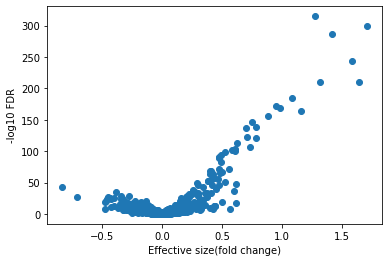

In [90]:
plt.scatter(
    df['effect_size'],
    -np.log10(df['mwu_fdr']))

plt.xlabel('Effective size(fold change)')
plt.ylabel('-log10 FDR')